In [1]:
%matplotlib inline

import numpy as np
from pandas import Series, DataFrame
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import sys
reload(sys)
sys.setdefaultencoding('utf-8')

import matplotlib as mpl
mpl.rcParams['font.sans-serif'] = ['FangSong_GB2312'] #指定默认字体  
mpl.rcParams['axes.unicode_minus'] = False # 解决保存图像是负号'-'显示为方块的问题
# sns.axes_style()，可以看到是否成功设定字体为微软雅黑。

以下代码可输出可用的中文字体

#! /usr/bin/env python
# -*- coding: utf-8 -*-
from matplotlib.font_manager import FontManager
import subprocess

fm = FontManager()
mat_fonts = set(f.name for f in fm.ttflist)

output = subprocess.check_output(
    'fc-list :lang=zh -f "%{family}\n"', shell=True)
# print '*' * 10, '系统可用的中文字体', '*' * 10
# print output
zh_fonts = set(f.split(',', 1)[0] for f in output.split('\n'))
available = mat_fonts & zh_fonts

print '*' * 10, '可用的字体', '*' * 10
for f in available:
    print f

### Table 1

In [2]:
kz_temp_series = pd.read_pickle('kz_temp_series.pkl')

In [3]:
kz_station_info = pd.read_pickle('kz_station_info.pkl')

In [4]:
pd.set_option('display.max_rows',6)

In [5]:
mean_jan = kz_temp_series.loc['1960-1':'2009-1':12].mean(axis=0)
mean_jan.name = 'MEAN_JAN'
mean_jul = kz_temp_series.loc['1960-7':'2009-7':12].mean(axis=0)
mean_jul.name = 'MEAN_JUL'

In [6]:
kz_table1_basic_info = kz_station_info.set_index('STATION_NAME').join(mean_jan).join(mean_jul)

In [7]:
kz_table1_basic_info.rename(index=str.title, columns=str.title, inplace=True)

In [8]:
kz_table1_basic_info

,Elevation,Latitude,Longitude,Mean_Jan,Mean_Jul
STATION_NAME,,,,,
Aktobe,219,50.2831,57.1500,-13.394,22.618
Aralskoe More,62,46.7794,61.6694,-11.444,26.864
Uralsk,36,51.2500,51.4000,-11.552,22.628
...,...,...,...,...,...
Petropavlovsk,142,54.8331,69.1500,-16.724,19.550
Zharkent,645,44.1667,80.0667,-6.898,24.426
Uil,128,49.0667,54.6831,-11.498,24.780


In [9]:
# kz_table1_basic_info.to_excel('kz_table1_basic_info.xlsx')

### Figure 1, location of stations

In [10]:
%matplotlib inline
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import cartopy.feature as cfeature


import cartopy.io.shapereader as shpreader

shpfilename = shpreader.natural_earth(resolution='50m',
                                      category='cultural',
                                      name='admin_0_countries')

reader = shpreader.Reader(shpfilename)

In [11]:
import itertools

def extract_geometries(reader, select_dict):
    records = reader.records()
    
    key = select_dict.keys()[0]
    value = select_dict[key]
    
    filter_geo = lambda x: x.attributes[key]==value
    return [item.geometry for item in itertools.ifilter(filter_geo,records)]

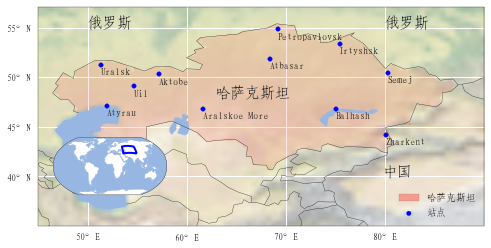

In [12]:
plt.figure(figsize=(8,4))

ax = plt.subplot(111,projection=ccrs.PlateCarree())
ax.stock_img()
extent = [45,90,35,55]
ax.set_extent(extent)
ax.set_xticks([50,60,70,80])
ax.set_yticks([40,45,50,55])

from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)

select_dict = {'name':'Kazakhstan'}

ax.add_geometries(extract_geometries(reader,select_dict),ccrs.PlateCarree(),\
                 facecolor='red',edgecolor='black',alpha=0.1,linewidth=0)

ax.add_feature(cfeature.LAKES,zorder=1)
ax.add_feature(cfeature.BORDERS,zorder=2)
ax.add_feature(cfeature.OCEAN,zorder=3)

lat_KZ = np.array(kz_station_info['LATITUDE'])
lon_KZ = np.array(kz_station_info['LONGITUDE'])
station_plot = ax.scatter(lon_KZ,lat_KZ, color='b',transform=ccrs.Geodetic(),label='Stations',zorder=5)


ax.text(50, 55, '俄罗斯', transform=ccrs.Geodetic(),size=15)
ax.text(80, 55, '俄罗斯', transform=ccrs.Geodetic(),size=15)
ax.text(80, 40, '中国', transform=ccrs.Geodetic(),size=15)
ax.text(63, 48, '哈萨克斯坦', transform=ccrs.Geodetic(),size=15)


import matplotlib.patches as mpatches

# make two proxy artists to add to a legend
kz_legend_proxy = mpatches.Rectangle((0, 0), 1, 1, facecolor="red",alpha=0.3)
labels = [u'哈萨克斯坦',u'站点']

plt.legend([kz_legend_proxy,station_plot], labels,\
            loc='lower right')

sub_ax = plt.axes([0.15, 0.24, 0.2, 0.2], projection=ccrs.Robinson())
sub_ax.add_feature(cfeature.OCEAN, zorder=0)

import shapely.geometry as sgeom
extent_box = sgeom.box(extent[0], extent[2], extent[1], extent[3])
sub_ax.add_geometries([extent_box], ccrs.Geodetic(), color='none',
                          edgecolor='blue', linewidth=2)

for index, row in kz_station_info.iterrows():
    ax.text(row.LONGITUDE, row.LATITUDE-1,row.STATION_NAME.title(), transform=ccrs.Geodetic(), zorder=5)

plt.savefig('哈图一.png',dpi=1000)

### Figure 2, illustration

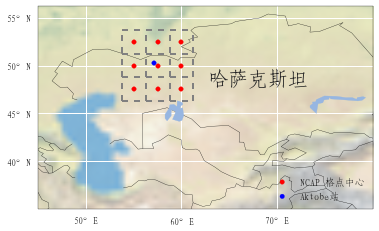

In [13]:
import matplotlib.ticker as mticker

ax = plt.axes(projection=ccrs.PlateCarree())

ax.stock_img()
ax.set_extent([45,80,35,55])

ax.set_xticks([50,60,70])
ax.set_yticks([40,45,50,55])

from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)


ax.add_feature(cfeature.BORDERS)
ax.add_feature(cfeature.LAKES)

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', linestyle='--')
gl.xlocator = mticker.FixedLocator(np.arange(53.75,63.75,2.5))
gl.ylocator = mticker.FixedLocator(np.arange(46.25,56.25,2.5))

p_aktobe = ax.scatter(57.1500, 50.2831, color='blue',transform=ccrs.PlateCarree(),label='Stations')
p_ncep = ax.scatter([55,55,55,57.5,57.5,57.5,60,60,60], [47.5,50,52.5,47.5,50,52.5,47.5,50,52.5], color='red',transform=ccrs.PlateCarree(),label='Stations')
gl.xlabels_top = False
gl.ylabels_right = False
gl.xlabels_bottom = False
gl.ylabels_left = False

kz_legend_proxy = mpatches.Rectangle((0, 0), 1, 1, edgecolor='black', facecolor='w', ls='dashed',lw=2)
labels = ['NCAP 格点中心','Aktobe站']

plt.legend([p_ncep,p_aktobe], labels,\
            loc='lower right')

ax.text(63, 48, '哈萨克斯坦', transform=ccrs.Geodetic(),size=20)

plt.savefig('哈图二.png',dpi=1000)

## predictors selection process

* heatmap for the relationship between potential predictors and temperatures by month and site
* boxplot for predictors selected to verify the candidates
* self heatmap between predictors to examine self-correlation
* scatter plot for one site and two months to check linear trends.

## Correlation heatmaps

## LOAD RESULT PICKLES

In [14]:
potential_predictors = pd.read_pickle('potential_predictors.pkl')

In [15]:
potential_predictors

,PC_VALUE,YEAR,EV,I_PC,MONTH,VAR_NAME,LEVEL,STATION_NAME,P_NAME
0,-1.223431,1960,0.956557,1,1,air,925,AKTOBE,air925
1,-2.272114,1961,0.956557,1,1,air,925,AKTOBE,air925
2,-1.069075,1962,0.956557,1,1,air,925,AKTOBE,air925
...,...,...,...,...,...,...,...,...,...
106547,-0.191719,2007,0.082115,2,12,vwnd,200,UIL,vwnd200
106548,-0.550271,2008,0.082115,2,12,vwnd,200,UIL,vwnd200
106549,0.071014,2009,0.082115,2,12,vwnd,200,UIL,vwnd200


### heatmap for all

In [16]:
def get_monthly_series(df, start_year_month, station_name, end_year_month=None):
    
    series_of_month = df.ix[start_year_month:end_year_month:12, station_name]
    
    return series_of_month


In [17]:
R2_list = []
year_start = potential_predictors.YEAR.min()
year_end = potential_predictors.YEAR.max()

for key, value in  potential_predictors.groupby(['MONTH','STATION_NAME','VAR_NAME','LEVEL','I_PC']):
    
    key = list(key)
    start_date = str(year_start)+'-'+str(key[0])
    end_date = str(year_end)+'-'+str(key[0])
    station_name = key[1]

    predictand = get_monthly_series(kz_temp_series,start_date,station_name,end_date)   

    predictor = value['PC_VALUE']
    
    corr_value = np.corrcoef(predictand, predictor)[0,1] ** 2
    
    element = {'MONTH':key[0], 'STATION_NAME':station_name, 'VAR':key[2], 'LEVEL':key[3], 'I_PC':key[4], 'CORR_COEF':corr_value}
    
    R2_list.append(element)

R2_df = pd.DataFrame(R2_list)

R2_df

,CORR_COEF,I_PC,LEVEL,MONTH,STATION_NAME,VAR
0,0.001345,1,200,1,AKTOBE,air
1,0.386285,1,500,1,AKTOBE,air
2,0.677865,1,925,1,AKTOBE,air
...,...,...,...,...,...,...
2128,0.464538,2,500,12,ZHARKENT,vwnd
2129,0.283858,1,925,12,ZHARKENT,vwnd
2130,0.007461,2,925,12,ZHARKENT,vwnd


In [18]:
R2_df['P_NAME'] = R2_df['VAR'].apply(str) + R2_df['LEVEL'].apply(int).apply(str) + '_' + R2_df['I_PC'].apply(str)
R2_df.reset_index(inplace=True)
R2_all_table = R2_df.set_index(['MONTH','STATION_NAME','P_NAME'])['CORR_COEF'].unstack('P_NAME')

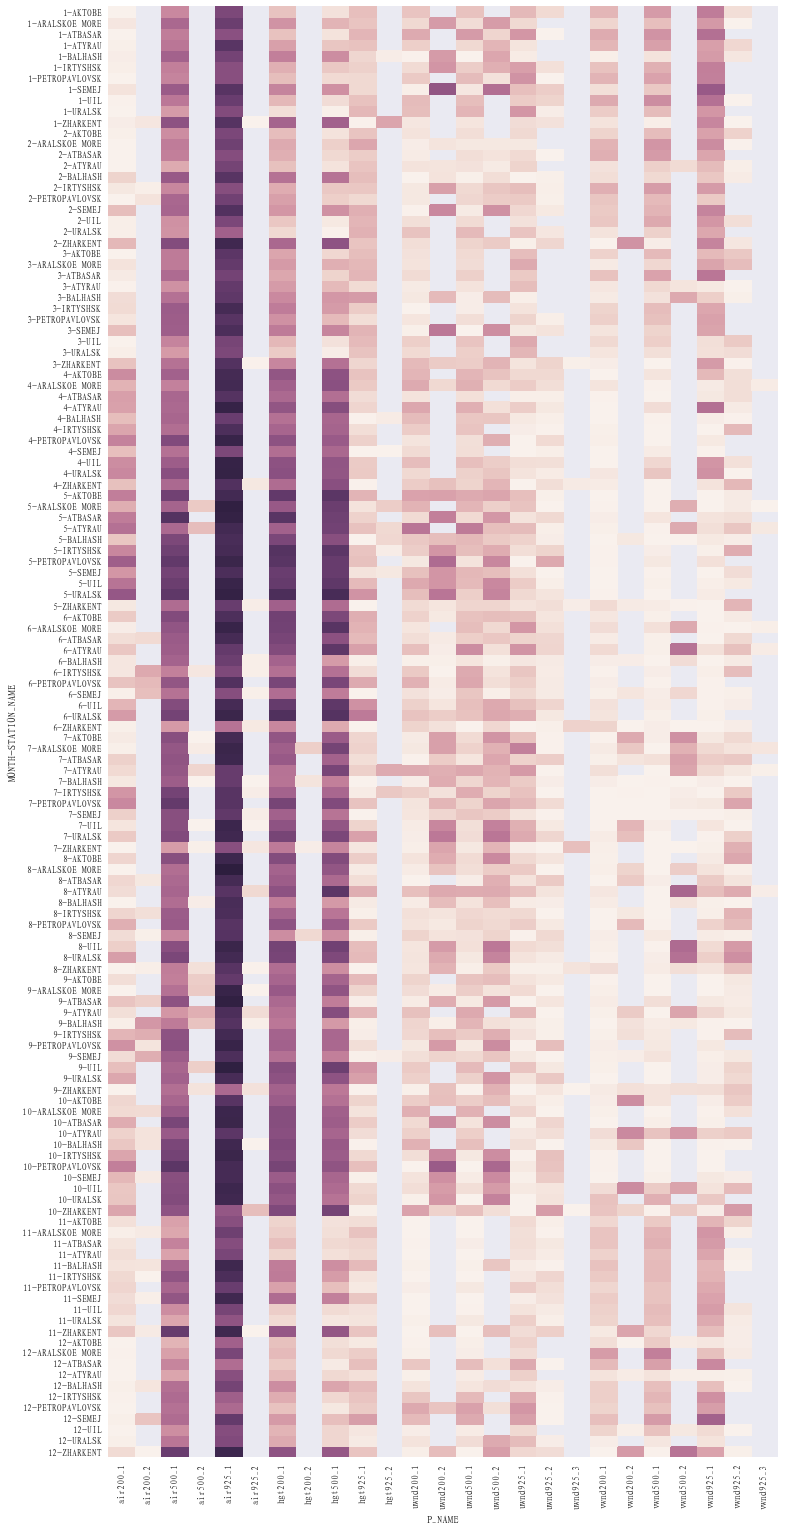

In [19]:
f, ax = plt.subplots(figsize=(12,26))

ax = sns.heatmap(R2_all_table,cbar=False)

### heat map for averaged station

In [20]:
def plot_heatmap(CC_df, ax=False, cbar_ax=None):
    CC_df = CC_df.set_index('I_PC').loc[1]
    CC_df['P_NAME'] = CC_df['VAR'].apply(str) + CC_df['LEVEL'].apply(int).apply(str)
    CC_df = CC_df.reset_index()
    CC_df = CC_df.set_index(['MONTH','STATION_NAME','P_NAME'])['CORR_COEF'].unstack('P_NAME')
    CC_df = CC_df.reset_index().groupby('MONTH').mean()
    
    sns.heatmap(CC_df, ax=ax, annot=True, cbar_ax=cbar_ax)
    ax.set_xlabel('')

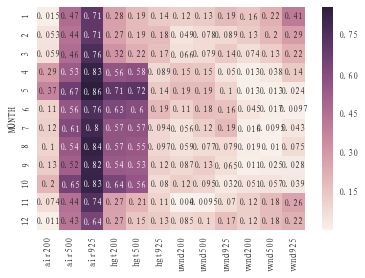

In [21]:
fig, ax = plt.subplots(1)

plot_heatmap(R2_df, ax=ax)

### heatmap for all with stations ordered by their ELEVATIONs

In [22]:
R2_all_table_E = R2_df.set_index(['MONTH','STATION_NAME','P_NAME'])['CORR_COEF'].unstack('P_NAME')

# append  elevation properties
R2_all_table_E = R2_all_table_E.reset_index('MONTH').join(kz_station_info.set_index('STATION_NAME'))

# sort value by elevation
R2_all_table_E = R2_all_table_E.sort_values(by=['MONTH','ELEVATION'])

R2_all_table_E = R2_all_table_E.reset_index().set_index(['MONTH','STATION_NAME'])

# drop those columns appended 
# R2_all_table_E = R2_all_table_E.drop(R2_all_table_E.columns[-3:], axis=1)

In [23]:
# check elevation
R2_all_table_E

P_NAME               air200_1  air200_2  air500_1  air500_2  air925_1  \
MONTH STATION_NAME                                                      
1     ATYRAU         0.010094       NaN  0.459914       NaN  0.785269   
      URALSK         0.000332       NaN  0.308713       NaN  0.661420   
      ARALSKOE MORE  0.042880       NaN  0.520798       NaN  0.729724   
...                       ...       ...       ...       ...       ...   
12    ATBASAR        0.001722       NaN  0.395827       NaN  0.493735   
      BALHASH        0.008478  0.044403  0.484253       NaN  0.701671   
      ZHARKENT       0.081544  0.001467  0.732413       NaN  0.873016   

P_NAME               air925_2  hgt200_1  hgt200_2  hgt500_1  hgt925_1  \
MONTH STATION_NAME                                                      
1     ATYRAU              NaN  0.296663       NaN  0.157843  0.171093   
      URALSK              NaN  0.071883       NaN  0.007621  0.209739   
      ARALSKOE MORE       NaN  0.340822       NaN  0.221881  0.162157   
...                       ...       ...       ...       ...       ...   
12    ATBASAR             NaN  0.143682       NaN  0.025484  0.178299   
      BALHASH             NaN  0.365602       NaN  0.275754  0.201720   
      ZHARKENT            NaN  0.618323       NaN  0.590821  0.163914   

P_NAME                 ...      vwnd200_1  vwnd200_2  vwnd500_1  vwnd500_2  \
MONTH STATION_NAME     ...                                                   
1     ATYRAU           ...       0.212914        NaN   0.295731        NaN   
      URALSK           ...       0.136233        NaN   0.192255        NaN   
      ARALSKOE MORE    ...       0.103621        NaN   0.178494        NaN   
...                    ...            ...        ...        ...        ...   
12    ATBASAR          ...       0.199806        NaN   0.290098        NaN   
      BALHASH          ...       0.124929        NaN   0.178910        NaN   
      ZHARKENT         ...       0.003499   0.317561   0.006382   0.464538   

P_NAME               vwnd925_1  vwnd925_2  vwnd925_3  ELEVATION  LATITUDE  \
MONTH STATION_NAME                                                          
1     ATYRAU          0.297520   0.097615        NaN        -22   47.1167   
      URALSK          0.327384        NaN        NaN         36   51.2500   
      ARALSKOE MORE   0.322223   0.000764        NaN         62   46.7794   
...                        ...        ...        ...        ...       ...   
12    ATBASAR         0.383639        NaN        NaN        304   51.8167   
      BALHASH         0.181789   0.001358        NaN        350   46.8000   
      ZHARKENT        0.283858   0.007461        NaN        645   44.1667   

P_NAME               LONGITUDE  
MONTH STATION_NAME              
1     ATYRAU           51.9167  
      URALSK           51.4000  
      ARALSKOE MORE    61.6694  
...                        ...  
12    ATBASAR          68.3667  
      BALHASH          75.0831  
      ZHARKENT         80.0667  

[132 rows x 28 columns]

In [24]:
# draw a heatmap if you want

# f, ax = plt.subplots(figsize=(12,26))

# ax = sns.heatmap(R2_all_table_E.drop(R2_all_table_E.columns[-3:], axis=1),cbar_kws={"orientation": "horizontal"})

### boxplot for comparison between predictor vectors

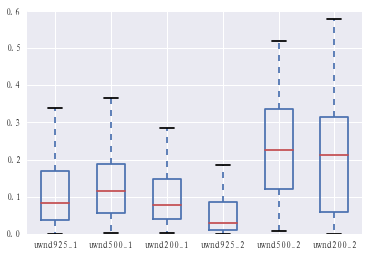

In [25]:
# from May to October: 5:10 

R2_all_table.ix[5:10,['uwnd925_1','uwnd500_1','uwnd200_1','uwnd925_2','uwnd500_2','uwnd200_2']].plot(kind='box')

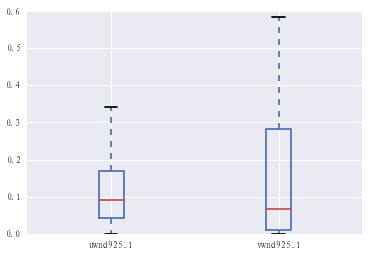

In [26]:
R2_all_table.ix[:,['uwnd925_1','vwnd925_1']].plot(kind='box')

### self correlation heat map

In [27]:
potential_predictors['P_NAME'] = potential_predictors['VAR_NAME'].apply(str) + potential_predictors['LEVEL'].apply(int).apply(str) 

In [28]:
self_corr = potential_predictors.loc[potential_predictors.I_PC==1,['MONTH','STATION_NAME','YEAR','P_NAME','PC_VALUE']]

In [29]:
self_corr = self_corr.set_index(['MONTH','STATION_NAME','P_NAME','YEAR']).unstack('YEAR')['PC_VALUE']

In [30]:
corr = self_corr.groupby(level=['MONTH','STATION_NAME']).apply(lambda x: np.corrcoef(x) ** 2).mean()

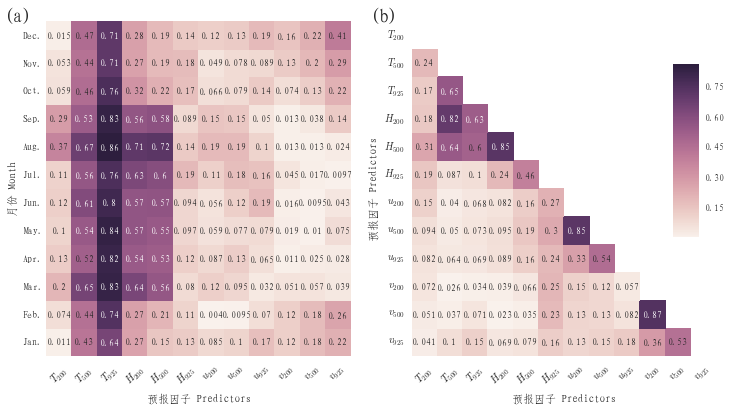

In [60]:
with sns.axes_style("white"):

    fig, axes = plt.subplots(1,2, figsize=(12,6))
    cbar_ax = fig.add_axes([.85, .4, .03, .4])
    
    mask = np.zeros_like(corr)
    mask[np.triu_indices_from(mask)] = True

    sns.heatmap(corr, mask=mask,ax=axes[1], annot=True,cbar_ax=cbar_ax)
    axes[1].set_xticklabels(['$T_{200}$', '$T_{500}$', '$T_{925}$', '$H_{200}$', '$H_{500}$', '$H_{925}$', '$u_{200}$', '$u_{500}$', '$u_{925}$', '$v_{200}$', '$v_{500}$', '$v_{925}$'],rotation=45)
    l=['$T_{200}$', '$T_{500}$', '$T_{925}$', '$H_{200}$', '$H_{500}$', '$H_{925}$', '$u_{200}$', '$u_{500}$', '$u_{925}$', '$v_{200}$', '$v_{500}$', '$v_{925}$']
    axes[1].set_yticklabels(l[::-1],rotation='horizontal')
    axes[1].set_xlabel('预报因子 Predictors')
    axes[1].set_ylabel('预报因子 Predictors')
    
    plot_heatmap(R2_df, ax=axes[0], cbar_ax=cbar_ax)
    axes[0].set_xticklabels(['$T_{200}$', '$T_{500}$', '$T_{925}$', '$H_{200}$', '$H_{500}$', '$H_{925}$', '$u_{200}$', '$u_{500}$', '$u_{925}$', '$v_{200}$', '$v_{500}$', '$v_{925}$'],rotation=45,style='italic')
    axes[0].set_yticklabels(['Jan.', 'Feb.', 'Mar.', 'Apr.', 'May.', 'Jun.', 'Jul.', 'Aug.', 'Sep.', 'Oct.', 'Nov.', 'Dec.'],rotation='horizontal')
    axes[0].set_xlabel('预报因子 Predictors')
    axes[0].set_ylabel('月份 Month')
    axes[0].text(-1.5,12, '(a)', fontsize=20,style='italic')
    axes[1].text(-1.5,12, '(b)', fontsize=20)
plt.savefig('哈图三.png',dpi=1000)

### scatter plot for linear trends

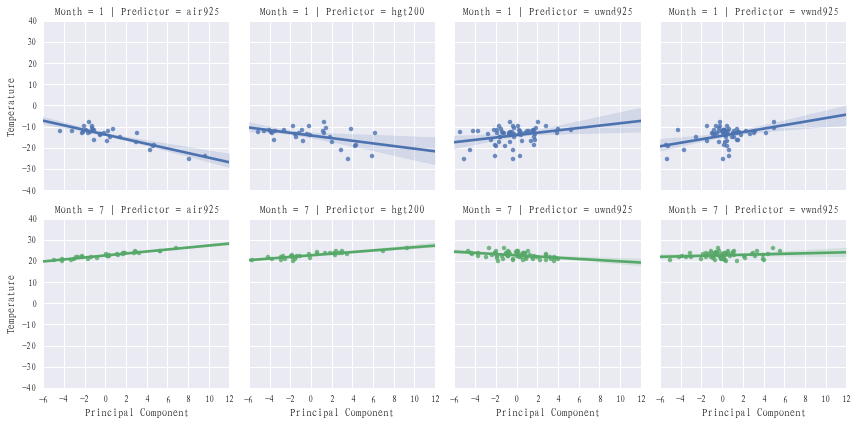

In [40]:
station_to_plot = 'AKTOBE'
linear_trend_p = potential_predictors.set_index(['STATION_NAME','MONTH'])[['P_NAME','YEAR','PC_VALUE']].ix[station_to_plot,:].ix[[1,7]]
linear_trend_p.reset_index(inplace=True)
linear_trend_t = kz_temp_series[station_to_plot].loc['1960-1':'1989-7':6]
linear_trend_t = linear_trend_t.reset_index()
linear_trend_t['Year'] = linear_trend_t['DATE'].apply(lambda x: int(str(x)[0:4]))
linear_trend_t['Month'] = linear_trend_t['DATE'].apply(lambda x: int(str(x)[5:7]))
linear_trend_table = pd.merge(linear_trend_p,linear_trend_t, left_on=['MONTH','YEAR'],right_on=['Month','Year'])
linear_trend_table = linear_trend_table.rename(columns={station_to_plot:'Temperature','P_NAME':'Predictor','PC_VALUE':'Principal Component'})
g = sns.FacetGrid(linear_trend_table[linear_trend_table.Predictor.isin(['air925','hgt200','uwnd925','vwnd925'])], col='Predictor', row="Month", hue='Month')
g.map(sns.regplot, 'Principal Component','Temperature')

#plt.savefig('KZ_fig_4_scattor.png',dpi=300)

## Analysis of results

## LOAD RESULT PICKLES

In [41]:
predicted_values = pd.read_pickle('predicted_values.pkl')
metrics_result = pd.read_pickle('metrics_result.pkl')
coefficients = pd.read_pickle('coefficients.pkl')

### timeseries plot

In [42]:
def plot_ts(predicted_values, ax,TRAIN_TEST='test',STATION_NAME=False):
    
    if not STATION_NAME:
        predicted = predicted_values.set_index('TRAIN_TEST').loc[TRAIN_TEST,:]
    else:
        predicted = predicted_values.set_index(['TRAIN_TEST', 'STATION_NAME']).loc[(TRAIN_TEST,STATION_NAME),:]
    
    mean_test = predicted.groupby(['MONTH'])['PREDICTED'].mean()
    std_test = predicted.groupby(['MONTH'])['PREDICTED'].std()
    
    start_year = str(predicted.YEAR.min())
    end_year = str(predicted.YEAR.max())
    
    mean_test_obs = kz_temp_series.loc[start_year:end_year].groupby(lambda x: x.month).mean().mean(axis=1)
    std_test_obs = kz_temp_series.loc[start_year:end_year].groupby(lambda x: x.month).mean().std(axis=1)
    
    ax.fill_between(mean_test.index, mean_test-1*std_test, mean_test+1*std_test, color='b', alpha=0.2)
    ax.plot(mean_test.index,mean_test,label='预测值 Prediction') 
    
    ax.fill_between(mean_test_obs.index, mean_test_obs-1*std_test_obs, mean_test_obs+1*std_test_obs, color='r', alpha=0.2)
    ax.plot(mean_test_obs.index,mean_test_obs,label='观测值 Obsevation',c='r') 
    


    ax.set_title(''+start_year+'-'+end_year+', '+ (STATION_NAME.title() if STATION_NAME else 'Mean'))
    ax.set_xlim([1,12])
    ax.set_xticks(range(1,13))
    ax.set_xticklabels(['Jan.', 'Feb.', 'Mar.', 'Apr.', 'May.', 'Jun.', 'Jul.', 'Aug.', 'Sep.', 'Oct.', 'Nov.', 'Dec.'],rotation=45)
    ax.set_xlabel('月份 Month')
    ax.set_ylabel('温度 Temperature (℃)')
    ax.legend(loc='best')

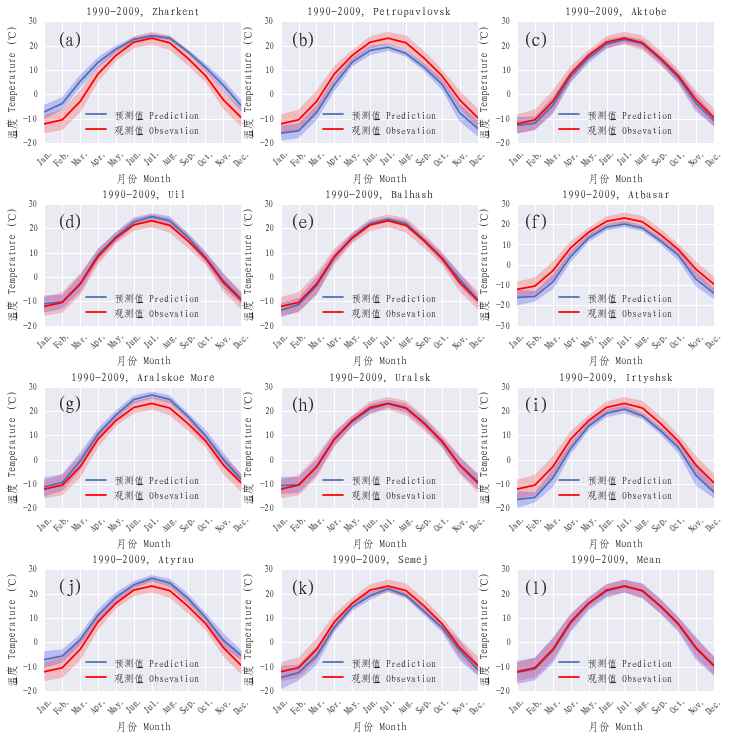

In [43]:
fig, axes = plt.subplots(4,3, figsize=(12,12))
fig.subplots_adjust(hspace=0.5)
axes = axes.flatten()

denote = 'abcdefghijkl'
for i,station in enumerate(list(set(predicted_values.STATION_NAME.values))): 
    plot_ts(predicted_values, axes[i],TRAIN_TEST='test',STATION_NAME=station)
    
plot_ts(predicted_values, axes[-1],TRAIN_TEST='test') 

plt.text(-24.5,245,'('+denote[0]+')',fontsize=20)
plt.text(-11.5,245,'('+denote[1]+')',fontsize=20)
plt.text(1.5,245,'('+denote[2]+')',fontsize=20)

plt.text(-24.5,170,'('+denote[3]+')',fontsize=20)
plt.text(-11.5,170,'('+denote[4]+')',fontsize=20)
plt.text(1.5,170,'('+denote[5]+')',fontsize=20)

plt.text(-24.5,95,'('+denote[6]+')',fontsize=20)
plt.text(-11.5,95,'('+denote[7]+')',fontsize=20)
plt.text(1.5,95,'('+denote[8]+')',fontsize=20)

plt.text(-24.5,20,'('+denote[9]+')',fontsize=20)
plt.text(-11.5,20,'('+denote[10]+')',fontsize=20)
plt.text(1.5,20,'('+denote[11]+')',fontsize=20)


plt.savefig('哈图五.png',dpi=1000)

### bar chart for errors

In [44]:
def plot_metrics(metrics_result, ax, MONTH=1, METRIC='RMSE', sort_by=False):
    metrics_result = metrics_result.set_index('MONTH').loc[MONTH]
    
    if sort_by:
        metrics_result = metrics_result.set_index('STATION_NAME').join(kz_station_info.set_index('STATION_NAME'))
        metrics_result = metrics_result.sort_values(sort_by)
        
    metrics_result[METRIC+'_test'].plot(kind='bar',ax=ax,title=METRIC+', Month='+str(MONTH))
    
    names = map(lambda x: str(x.title()[:4]) + '.',list(metrics_result.index.values))
    ax.set_xticklabels(names,rotation=90)
    ax.set_xlabel("")


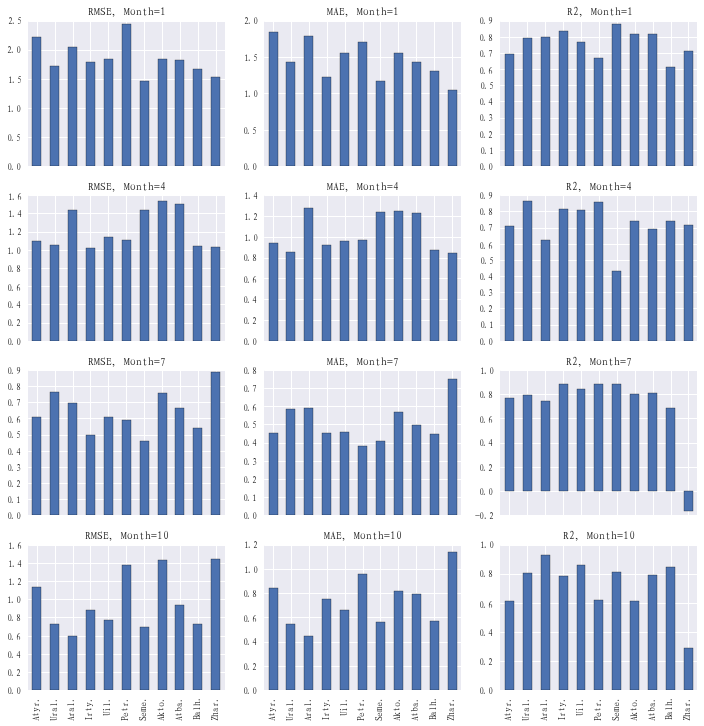

In [45]:
fig, axes = plt.subplots(4,3,figsize=(12,12),sharex=True)
plt.subplots_adjust(hspace=0.2)

SORT = 'ELEVATION'
for i, month in enumerate([1,4,7,10]):
    for j,metric in enumerate(['RMSE','MAE','R2']):
        plot_metrics(metrics_result, axes[i,j], MONTH=month, METRIC=metric, sort_by=SORT)
#plt.savefig('KZ_fig_6_error.png',dpi=300)

### error map

In [46]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import cartopy.feature as cfeature

In [47]:
def plot_metrics_map(metrics_result,fig, ax,  MONTH=False, METRIC='RMSE'):
    
    if MONTH!=False:
        metrics_result = metrics_result.set_index('MONTH').loc[MONTH]
        metrics_result = metrics_result.set_index('STATION_NAME').join(kz_station_info.set_index('STATION_NAME'))
    else:
        metrics_result = metrics_result.set_index('STATION_NAME').join(kz_station_info.set_index('STATION_NAME'))
        metrics_result = metrics_result.reset_index().groupby(['STATION_NAME']).mean()
    
    ax.stock_img()
    extent = [45,90,35,55]
    ax.set_extent(extent)
    ax.set_xticks([50,60,70,80])
    ax.set_yticks([40,45,50,55])
    
    from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)
    
    ax.add_feature(cfeature.LAKES)
    ax.add_feature(cfeature.BORDERS)
    ax.add_feature(cfeature.OCEAN)


    cm = plt.cm.get_cmap('Blues')
    
    norm = plt.Normalize(vmin = np.min(metrics_result[METRIC+'_test']), vmax = np.max(metrics_result[METRIC+'_test']), clip = False)

    station_plot = ax.scatter(metrics_result.LONGITUDE,metrics_result.LATITUDE,s=metrics_result[METRIC+'_test']*100, c=metrics_result[METRIC+'_test'], \
                              cmap=cm, transform=ccrs.Geodetic(),linewidth=1,alpha=0.9, label='Stations', zorder=5, norm=norm)
    ax.set_title(METRIC+(', Month='+str(MONTH) if MONTH else ''))
    fig.colorbar(station_plot)

   




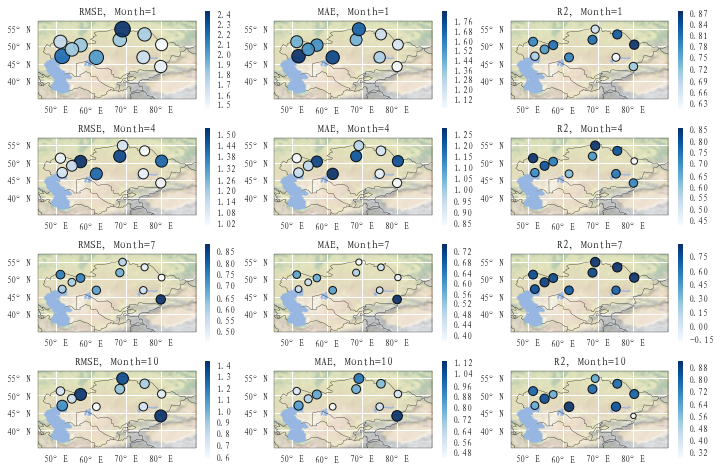

In [48]:
fig = plt.figure(figsize=(12,8))

for i, month in enumerate([1,4,7,10]):
    for j,metric in enumerate(['RMSE','MAE','R2']):
        plot_metrics_map(metrics_result,fig,plt.subplot(4,3,i*3+j+1,projection=ccrs.PlateCarree()), MONTH=month, METRIC=metric)

#plt.savefig('KZ_fig_6_error_map.png',dpi=300)

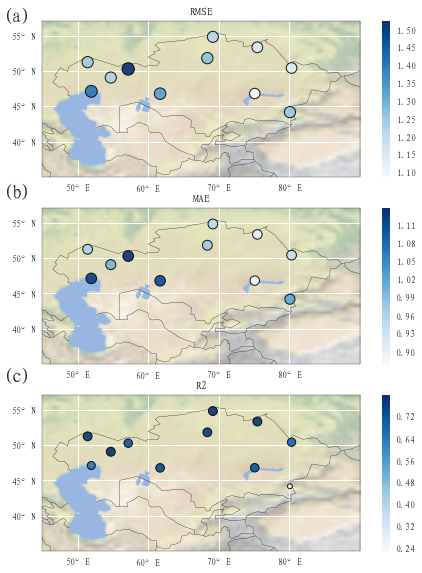

In [49]:
fig = plt.figure(figsize=(8,9.5))

for j,metric in enumerate(['RMSE','MAE','R2']):
    plot_metrics_map(metrics_result,fig,plt.subplot(3,1,j+1,projection=ccrs.PlateCarree()), METRIC=metric)
    
plt.text(40,110, '(a)', fontsize=20)
plt.text(40,85, '(b)', fontsize=20)
plt.text(40,59, '(c)', fontsize=20)
plt.savefig('哈图六.png',dpi=1000)

### box plot for seasons

In [50]:
month_to_season_dct = {
    1: 'DJF', 2: 'DJF',
    3: 'MAM', 4: 'MAM', 5: 'MAM',
    6: 'JJA', 7: 'JJA', 8: 'JJA',
    9: 'SON', 10: 'SON', 11: 'SON',
    12: 'DJF'
}

def plot_season_metrics(metrics_result, ax, METRIC='RMSE'):
    
    metrics_result['SEASON'] = metrics_result['MONTH'].map(month_to_season_dct)
    metrics_result = metrics_result.groupby(['SEASON','STATION_NAME'])[METRIC+'_test'].mean().unstack('SEASON')
    metrics_result.reindex(columns=['MAM','JJA','SON','DJF']).plot(ax=ax,kind='box',title=METRIC)
    ax.set_xlabel('季度 Seasons')
    ax.set_ylabel('统计值 Statistics')

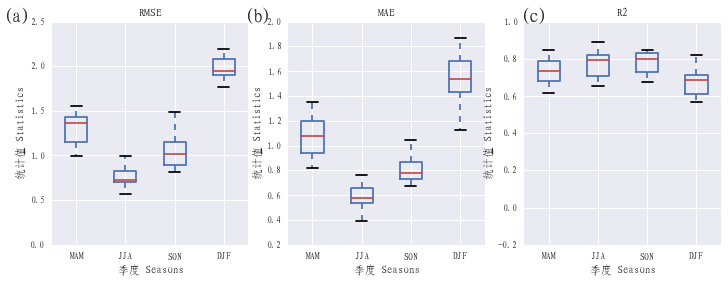

In [51]:
fig,axes = plt.subplots(1,3,figsize=(12,4))

for i,metric in enumerate(['RMSE','MAE','R2']):
    plot_season_metrics(metrics_result, axes[i], METRIC=metric)

plt.text(-10,1, '(a)', fontsize=20)
plt.text(-5.1,1, '(b)', fontsize=20)
plt.text(0.5,1, '(c)', fontsize=20)    

plt.savefig('哈图七.png',dpi=1000)

In [52]:
coefs = pd.read_pickle('coefs.pkl')

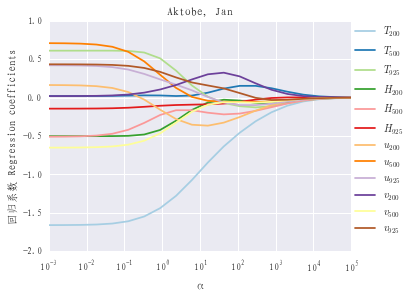

In [58]:
plt.figure(figsize=(6,4))
n_alphas = 20
alphas = np.logspace(-3, 5, n_alphas)
y = coefs[coefs.MONTH==1].ix[:,3:-1]
ax = plt.gca()
ax.set_color_cycle(sns.color_palette("Paired", 12))
ax.set_position([0.15,0.125,0.7,0.8])
ax.plot(alphas,y)
ax.set_xscale('log')
#ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.xlabel('α')
plt.ylabel('回归系数 Regression coefficients')
plt.title('Aktobe, Jan')
ax.legend(['$T_{200}$', '$T_{500}$', '$T_{925}$', '$H_{200}$', '$H_{500}$', '$H_{925}$', '$u_{200}$', '$u_{500}$', '$u_{925}$', '$v_{200}$', '$v_{500}$', '$v_{925}$'],loc=(1,.05))
plt.savefig('哈图四.png',dpi=1000)